In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
import pickle

import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from spacy.lang.zh.examples import sentences 

from TCSP import read_stopwords_list
# nlp = spacy.load("zh_core_web_sm")
# import zh_core_web_sm
import zhon

## Topic Model Construction

In [ ]:
import glob
import re
chunks = []
parquets = sorted(glob.glob("chunks/processed/*.parquet"), key=lambda x: int(re.search(r"\d+", x)[0]))
for chunkname in parquets:
    chunks.append(pd.read_parquet(chunkname))
df = pd.concat(chunks)
df = df.reset_index().drop("index", axis=1)

In [ ]:
ddf = pd.read_parquet("china_us_contents.parquet")

In [ ]:
ddf['tokenized_text'] = df['text']

In [ ]:
ddf.to_parquet("china_us_contents_with_tokens.parquet")

In [ ]:
df = pd.read_parquet("china_us_contents_with_tokens.parquet")

In [ ]:
texts = df['tokenized_text'].values
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_above=0.90)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# Save the list using pickle
with open('results/gensim_lda/dic.pkl', 'wb') as file:
    pickle.dump(dictionary, file)
    
with open('results/gensim_lda/corpus.pkl', 'wb') as file:
    pickle.dump(corpus, file)

In [ ]:
# Load the list from the file
import pickle
with open('results/gensim_lda/dic.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('results/gensim_lda/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)

In [ ]:
from gensim.models import LdaMulticore
lda_10 = LdaMulticore(corpus, num_topics=10, id2word=dictionary)
for idx, topic in lda_10.print_topics(num_topics=10, num_words=20):
    print(f"Topic {idx}: {topic}")
lda_10.save("results/gensim_lda/lda_10")

In [ ]:
from gensim.models import LdaMulticore
lda_15 = LdaMulticore(corpus, num_topics=15, id2word=dictionary)
for idx, topic in lda_15.print_topics(num_topics=15, num_words=20):
    print(f"Topic {idx}: {topic}")
lda_15.save("results/gensim_lda/lda_15")

In [ ]:
lda_20 = LdaMulticore(corpus, num_topics=20, id2word=dictionary)
for idx, topic in lda_20.print_topics(num_topics=20, num_words=20):
    print(f"Topic {idx}: {topic}")
lda_20.save("results/gensim_lda/lda_20")

In [ ]:
from gensim.models import LdaMulticore
lda_30 = LdaMulticore(corpus, num_topics=30, id2word=dictionary)
for idx, topic in lda_30.print_topics(num_topics=30, num_words=20):
    print(f"Topic {idx}: {topic}")
lda_30.save("results/gensim_lda/lda_30")

## Document Frequencies

In [ ]:
from gensim.models import LdaMulticore
lda = LdaMulticore.load('results/gensim_lda/lda_10')
for idx, topic in lda.print_topics(num_topics=10, num_words=20):
    print(f"Topic {idx}: {topic}")

In [ ]:
# Load the list from the file
import pickle
with open('results/gensim_lda/dic.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('results/gensim_lda/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
doc_topics = [lda[doc] for doc in corpus]

In [ ]:
top_1_topic = [doc_topic[0][0] for doc_topic in doc_topics]

In [ ]:
# Save the list using pickle
with open('results/gensim_lda/doc_topics_lda_10.pkl', 'wb') as file:
    pickle.dump(doc_topics, file)
    
with open('results/gensim_lda/doc_top_1_topic_lst_lda_10.pkl', 'wb') as file:
    pickle.dump(top_1_topic, file)

In [2]:
import pickle
with open('results/gensim_lda/doc_topics_lda_10.pkl', 'rb') as file:
    doc_topics = pickle.load(file)
    
with open('results/gensim_lda/doc_top_1_topic_lst_lda_10.pkl', 'rb') as file:
    top_1_topic = pickle.load(file)

In [3]:
df = pd.read_parquet("china_us_contents.parquet")

In [5]:
df['top_topic'] = np.asarray(top_1_topic) + 1

In [6]:
count_df = df.groupby(['top_topic', 'source']).count()['text'].unstack()

# Calculate the proportions within each source
prop_df = count_df.div(count_df.sum(axis=0), axis=1)

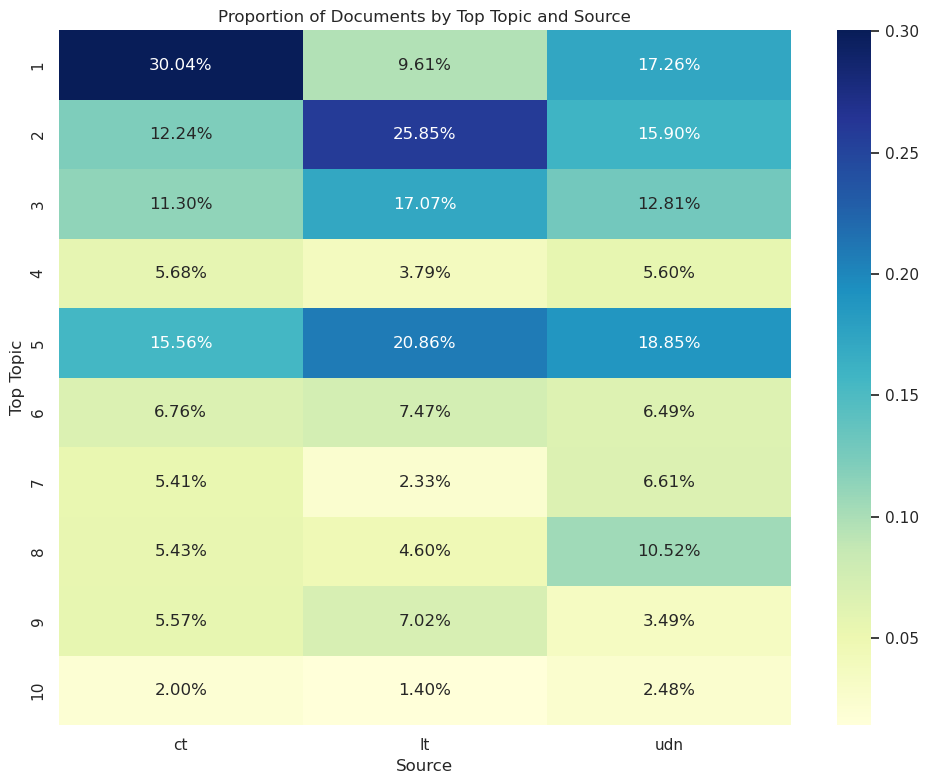

In [7]:
import numpy as np
annot_labels = np.empty_like(prop_df, dtype=object)
for i in range(prop_df.shape[0]):
    for j in range(prop_df.shape[1]):
        annot_labels[i, j] = f"{prop_df.iloc[i, j]:.2%}"

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(prop_df, cmap='YlGnBu', annot=annot_labels, fmt='', annot_kws={"size": 12})
plt.xlabel('Source')
plt.ylabel('Top Topic')
plt.yticks(np.arange(0.5, 10.5, 1), labels=range(1,11))
plt.title('Proportion of Documents by Top Topic and Source')
plt.tight_layout()
plt.show()

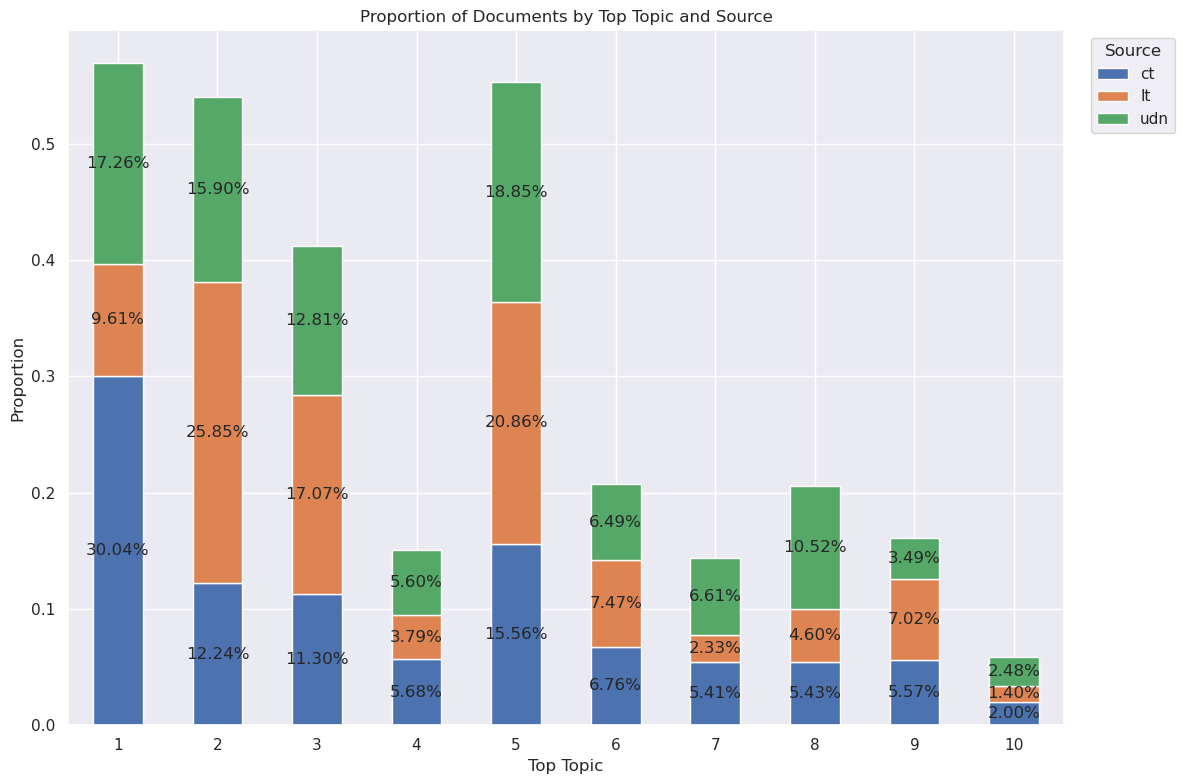

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a dataframe 'df' with columns 'top_topic', 'source', and 'document_id'

# Perform groupby and count the documents for each combination of 'top_topic' and 'source'
count_df = df.groupby(['top_topic', 'source']).count()['text'].unstack()

# Calculate the proportions within each source
prop_df = count_df.div(count_df.sum(axis=0), axis=1)

# Create a multilevel bar chart
ax = prop_df.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_xlabel('Top Topic')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Documents by Top Topic and Source')
ax.legend(title='Source', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.xaxis.set_tick_params(rotation=0)

# Display percentage labels on each bar segment
for c in ax.containers:
    labels = [f'{v.get_height():.2%}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

plt.tight_layout()
plt.show()

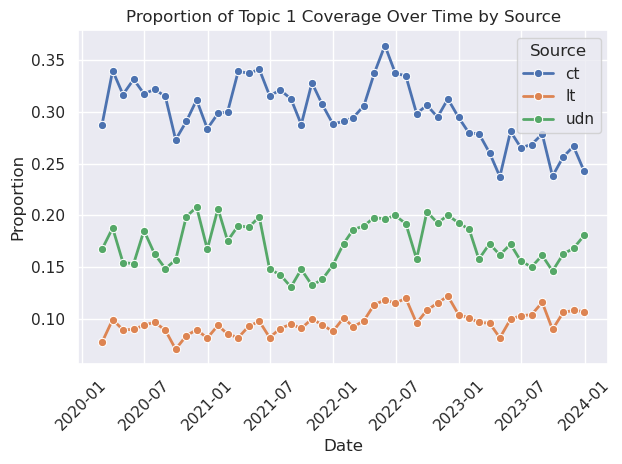

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a dataframe 'df' with columns 'top_topic', 'source', 'document_id', and 'date'

# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group by source, date, and top_topic, and count the occurrences
counts_df = df.groupby(['source', pd.Grouper(key='date', freq='M'), 'top_topic']).size().reset_index(name='count')

# Calculate the total count for each source and date
total_counts = counts_df.groupby(['source', 'date'])['count'].sum().reset_index(name='total_count')

# Merge the counts_df and total_counts
merged_df = pd.merge(counts_df, total_counts, on=['source', 'date'])

# Calculate the proportions for each source, date, and top_topic
merged_df['proportion'] = merged_df['count'] / merged_df['total_count']

# Filter the merged dataframe to include only topic 3
topic_3_proportions = merged_df[merged_df['top_topic'] == 1]

# Create a line plot
sns.lineplot(data=topic_3_proportions, x='date', y='proportion', hue='source', linewidth=2, marker='o')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Proportion of Topic 1 Coverage Over Time by Source')
plt.legend(title='Source')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df['topics'] = doc_topics

# Create a new DataFrame to store the topic probabilities
topic_probs_df = pd.DataFrame(columns=['document', 'topic', 'probability', 'source'])

# Iterate over each document
for i, row in df.iterrows():
    # Get the topics and their probabilities for the current document
    topics_probs = row['topics']  # Assuming the topics and probabilities are stored as a list of tuples
    source = row['source']
    
    # Iterate over each topic and its probability
    for topic, prob in topics_probs:
        new_row = pd.DataFrame({'document': [i], 'topic': [topic], 'probability': [prob], 'source': [source]})
        topic_probs_df = pd.concat([topic_probs_df, new_row], ignore_index=True)

# Group by topic and source, and calculate the sum of probabilities
prob_sum_df = topic_probs_df.groupby(['topic', 'source'])['probability'].sum().unstack()

# Calculate the proportions within each source
prop_df = prob_sum_df.div(prob_sum_df.sum(axis=0), axis=1)

import numpy as np

annot_labels = np.empty_like(prop_df, dtype=object)
for i in range(prop_df.shape[0]):
    for j in range(prop_df.shape[1]):
        annot_labels[i, j] = f"{prop_df.iloc[i, j]:.2%}"

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(prop_df, cmap='YlGnBu', annot=annot_labels, fmt='', annot_kws={"size": 12})
plt.xlabel('Source')
plt.ylabel('Topic')
plt.title('Proportion of Topic Probabilities by Source')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(prop_df, cmap='YlGnBu', annot=annot_labels, fmt='', annot_kws={"size": 12})
plt.xlabel('Source')
plt.ylabel('Topic')
plt.title('Proportion of Topic Probabilities by Source')
plt.tight_layout()
plt.show()